# Importings

In [533]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor                     # Validation model
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
import xgboost as xgb 
from sklearn.cluster import KMeans
train = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Train.csv') 
test = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200


In [534]:
max_lon = 9.216568750635945
max_lat = 45.51461188207373


def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    r = 6371
    return c * r
for df in (train,test): 
    df['distance'] = df.apply(lambda row: haversine(row['LON'], row['LAT'], max_lon, max_lat), axis=1)


In [535]:
def post_process(test_data,y,feature_to_mean='Month') -> int:
    test_data['target'] = y
    test_data['target_month'] = test_data[feature_to_mean].map(test_data[[feature_to_mean,'target']].groupby(feature_to_mean)['target'].mean())
    test_data.drop(columns='target',inplace=True)
    return test_data['target_month']

In [536]:
'''columns_to_aggregate = train.columns
agg_funcs = ['mean', 'std', 'min', 'max'] 

def add_aggregated_features(dataset, columns, funcs):
    dataset = dataset.copy()
    for column in columns:
        agg_features_id = dataset.groupby('ID')[column].agg(funcs)
        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]
        dataset = dataset.merge(agg_features_id, on='ID')
    return dataset

# Apply the function to both train and test datasets
train = add_aggregated_features(train, columns_to_aggregate, agg_funcs)
test = add_aggregated_features(test, columns_to_aggregate, agg_funcs)'''

"columns_to_aggregate = train.columns\nagg_funcs = ['mean', 'std', 'min', 'max'] \n\ndef add_aggregated_features(dataset, columns, funcs):\n    dataset = dataset.copy()\n    for column in columns:\n        agg_features_id = dataset.groupby('ID')[column].agg(funcs)\n        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]\n        dataset = dataset.merge(agg_features_id, on='ID')\n    return dataset\n\n# Apply the function to both train and test datasets\ntrain = add_aggregated_features(train, columns_to_aggregate, agg_funcs)\ntest = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"

In [537]:
for col in train.columns:
    print(col)    
    print(train[col].is_unique)
    print("___________________")

ID_Zindi
False
___________________
Date
False
___________________
ID
False
___________________
LAT
False
___________________
LON
False
___________________
Precipitation
False
___________________
LST
False
___________________
AAI
False
___________________
CloudFraction
False
___________________
NO2_strat
False
___________________
NO2_total
False
___________________
NO2_trop
False
___________________
TropopausePressure
False
___________________
GT_NO2
False
___________________
distance
False
___________________


In [538]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,distance
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000,86584.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051,78.323748
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838,72.501944
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000,2.709081
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000,26.854948
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000,47.020214
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000,121.181069
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333,262.923172


# Feature Engineering

In [539]:
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [540]:
"""train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    #df['target_month'] = df['Month'].map(df[['Month','GT_NO2']].groupby('Month')['GT_NO2'].mean())
    #df['Month'] = df['Date'].dt.is_month_start
    #df['Year'] =  df['Date'].dt.year
    #df.set_index(df['Date'],inplace=True)
    #df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df.drop(columns=['ID_Zindi'],inplace=True)
    
#Lags
#for df in(train,test): 
    #df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    #df['Precipitation_log'] =  np.log(df['Precipitation'] + 1e-9)
    #df['CloudFraction_diff'] = df['CloudFraction'] / df['NO2_strat']
    #df['CloudFraction_diff2'] = df['CloudFraction'] / df['NO2_total']
    #['Precipitation_fractional'] = df['Precipitation'] * 0.00001
    #df['TropopausePressure_fractional'] = round(df['TropopausePressure'] * 0.00001,2)
    #df['cluster'] = kmeans.fit_transform(df[['LAT', 'LON']])
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']

#for df in(train,test): 
    #Rolling (Moving Average)
    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()
#statsitics of similar variables

"""def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')
MeanSd('LON','LAT')"""

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_92366/1927459310.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_92366/1927459310.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'def MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)\n\nMeanSd(\'NO2_trop\',\'NO2_total\')\nMeanSd(\'LON\',\'LAT\')'

In [541]:
#for df in(train,test): 
    #df['LST_mean_60'] = df['LST'].rolling(60).mean()
    #df['Prec_mean_60'] = df['Precipitation'].rolling(60).mean()
    #df['AII_mean'] = df['AAI'].rolling(60).mean()
    #df['no2_total'] = df['NO2_total'].rolling(60).min()

    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()


def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        dataset[f"{feature}_rolling_std_30"] = dataset[feature].rolling(30).std()
        #dataset[f"{feature}_rolling_max_30"] = dataset[feature].rolling(30).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
#rolling('AAI')
#rolling('LST')
rolling('Precipitation')

In [542]:
'''columns_to_aggregate = [
    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat', 
    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction', 
    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60', 
    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'
]
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')
        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')
        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')
        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')


df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()
        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()
        df[f'{col}_rolling_max_30'] = df[col].rolling(window=30).max()
        df[f'{col}_rolling_min_30'] = df[col].rolling(window=30).min()'''

"columns_to_aggregate = [\n    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat', \n    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction', \n    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60', \n    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'\n]\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')\n        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')\n        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')\n        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')\n\n\ndf['Date'] = pd.to_datetime(df['Date'])\ndf = df.set_index('Date')\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()\n        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()\n

# Missing Values & Encoding

In [543]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=["Date"], axis=1,inplace=True)

In [544]:
from sklearn.preprocessing import OneHotEncoder
le = OneHotEncoder()
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

# CV and Modeling

In [545]:
#groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
#train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [546]:
""""import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

# Assuming you have your data in a DataFrame called train and a 'groups' column
# Also assuming 'GT_NO2' is your target column

model = LGBMRegressor(random_state=7)
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):
    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    return score

def lofo_analysis(train, target_col, groups, n_splits):
    base_rmse = []
    for train_idx, test_idx in cv.split(train.drop(columns=target_col), train[target_col], groups=groups):
        train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
        base_rmse.append(validate(train_v, test_v, target_col))
    base_score = np.array(base_rmse).mean()
    print('Base RMSE:', base_score)

    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        print(f'Evaluating feature: {col}')
        scores = []
        for train_idx, test_idx in cv.split(train.drop(columns=[target_col, col]), train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v.drop(columns=col), test_v.drop(columns=col), target_col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} removed, RMSE: {feature_rmse}')

    bad_features = [col for col in feature_importances if feature_importances[col] > base_score]
    good_features = [col for col in feature_importances if feature_importances[col] <= base_score]
    
    print('Good features:', good_features)
    print('Bad features:', bad_features)
    
    return good_features, bad_features, feature_importances

good_features, bad_features, feature_importances = lofo_analysis(train, 'GT_NO2', groups, n_splits)

print('Feature importances:')
for feature, importance in feature_importances.items():
    print(f'{feature}: {importance}')
""""

SyntaxError: unterminated string literal (detected at line 55) (4145511254.py, line 55)

In [ ]:
# 'LST', 'AAI', 'NO2_trop_rolling_max_60', 'CloudFraction_rolling_max_60'

In [547]:
model = LGBMRegressor(random_state=7)
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)
    
    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4817
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 23
[LightGBM] [Info] Start training from score 24.434701
std: 14.844616530580991
score: 10.378980066929463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4819
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 23
[LightGBM] [Info] Start training from score 22.752866


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 19.09580192108185
score: 11.2159069496673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4820
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 23
[LightGBM] [Info] Start training from score 22.615852


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 18.147840185499298
score: 12.35132318618915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4821
[LightGBM] [Info] Number of data points in the train set: 65760, number of used features: 23
[LightGBM] [Info] Start training from score 23.199636


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 15.385929166349635
score: 11.730710667255432
RMSE: 11.419230217510336
RMSE std: 0.7227167667668627
Standard Deviations: [np.float64(14.844616530580993), np.float64(19.09580192108185), np.float64(18.147840185499298), np.float64(15.385929166349635)]


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
pij;

In [ ]:
#11.581549939504997 with month , 
#12.246931687286574
#12.235259341356834
#12.231869616518921
#12.126333476852636
#11.728753513719479
#11.724263538742687
#11.728753513719479 
#11.711277895239192
#11.694341231865433
#11.671982426722977
#11.642227859275334 without the mean - with the custamized means of rolling
#11.314985626750522 
#11.314985626750522
#11.312413659993586
#11.135932399851725 
#11.728753513719479 best so far features = ['LAT', 'Month','NO2_trop_rolling_max_60','NO2_total_rolling_max_60','TropopausePressure_rolling_max_60','CloudFraction_rolling_max_60','Precipitation_rolling_max_60']
#11.40320255907346 with the ID LB = 9.571700669
#11.597286160951526 the distance feature

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y = model.predict(test)
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/SampleSubmission.csv')
smaple['GT_NO2'] = post_process(test,y)
smaple.to_csv('submissionpost2.csv',index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3464
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 16
[LightGBM] [Info] Start training from score 23.250548


In [548]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
#y_pred = model.predict(test)
#sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
#sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission1140320255907346.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 23
[LightGBM] [Info] Start training from score 23.250548


LGBMRegressor(random_state=7)

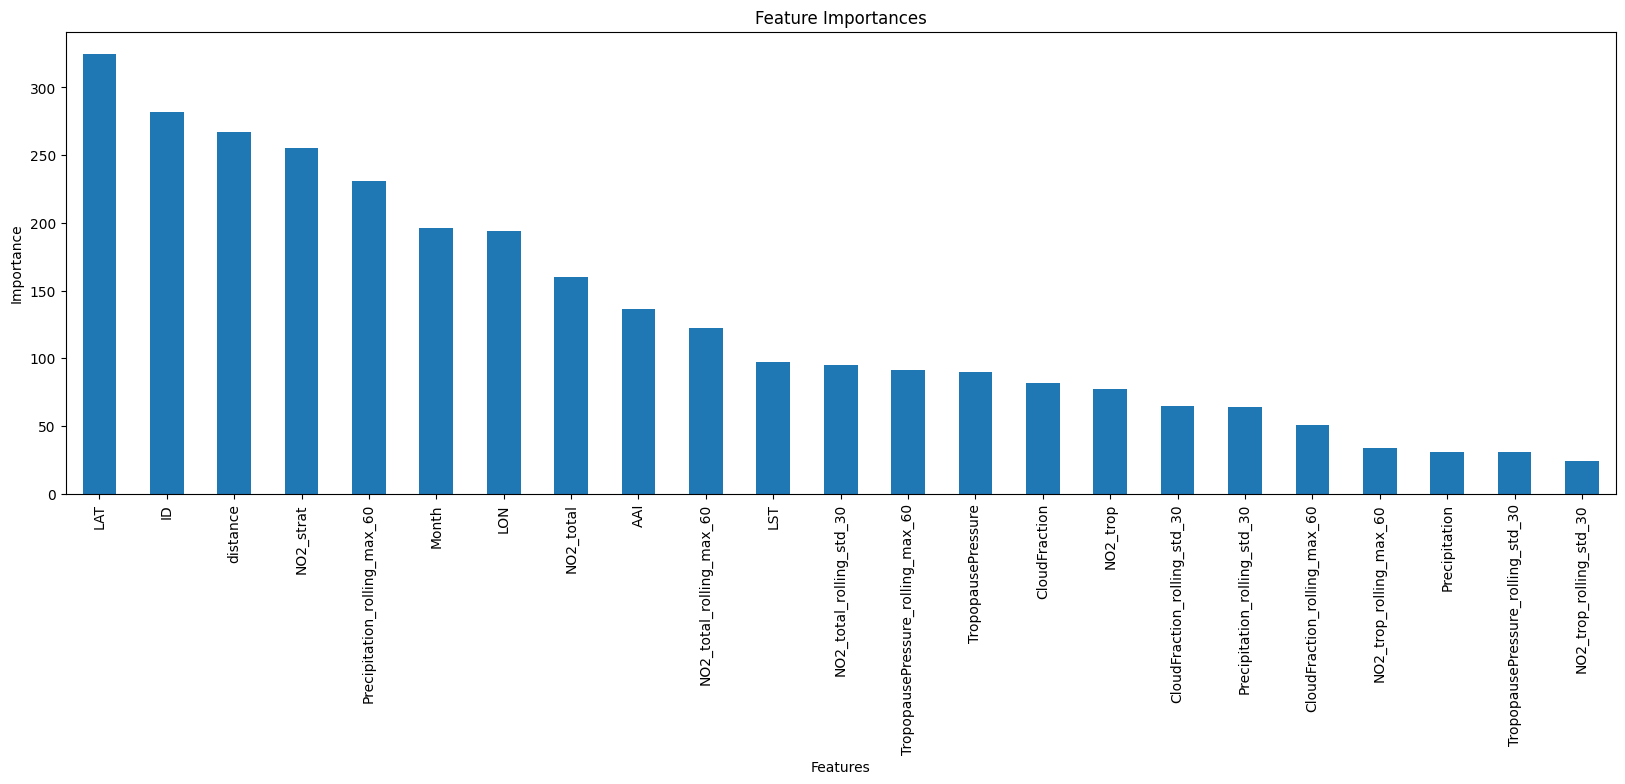

In [549]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(20, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
names

['ID',
 'LAT',
 'LON',
 'Precipitation',
 'LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure',
 'Month',
 'NO2_trop_rolling_max_60',
 'NO2_total_rolling_max_60',
 'TropopausePressure_rolling_max_60',
 'CloudFraction_rolling_max_60',
 'Precipitation_rolling_max_60']